# Neural ODE & SDE models
---

Цели:
- Познакомиться с Нейронными ОДУ
- Познакомиться с Нейронными СДУ
- Узнать, где их можно использовать

Содержание:
- [Neural ODE](#ode)
    - [Введение](#intro)
    - [Методы решения ОДУ](#ode_methods)
    - [Процесс обучения нейронных ОДУ](#ode_train)
    - [Примеры использования](#example)
- [Neural SDE](#sde)
    - [Сопряженные состояния SDE и воспроизводимый шум](#sde_adjoint)
    - [Виртуальное броуновское дерево](#bm)
- [Примеры использования](#models)
    - [Моделирование запасов продуктивной влаги в верхних слоях почвы методом нейронных дифференциальных уравнений](#soilw)
    - [Climate Modeling with Neural Diffusion Equations](#climate)

Ссылки:
1. [Neural Ordinary Differential Equations](https://arxiv.org/pdf/1806.07366.pdf)
2. [Знакомство с Neural ODE](https://habr.com/ru/companies/ods/articles/442002/)
3. [Efficient and Accurate Gradients for Neural SDEs](https://arxiv.org/pdf/2105.13493.pdf)
4. [Neural Controlled Differential Equations for Irregular Time Series](https://arxiv.org/abs/2005.08926)

Используемые пакеты:
1. [Репо torchdiffeq](https://github.com/rtqichen/torchdiffeq/)
2. [Репо torchsde](https://github.com/google-research/torchsde/)

<a name="ode"></a>
## Neural ODE

<a name="intro"></a>
### Введение

В 2018 году вышла статья [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366) и взяла **BEST PAPER AWARD** на *NeurIPS*. В чем была основная идея и какие проблемы решала данная статья?

Рассмотрим простую рекуррентную сеть, которая генерирует дискретные временные последовательности
$$
h_{t+1} = h_t + f(h_t, \theta_t)
$$
где $t=0,\dots,T$ — переменная дискретного времени и $h_t\in\mathbb{R}^D$ — состояния модели на $t$-ом шаге.

Вопрос: Что будет, если мы увеличим число слоев и уменьшим размер шага по времени? В пределе получим, что данное представление соответствует ОДУ первого порядка
$$
\dfrac{dh(t)}{dt} = f(h(t), t, \theta)
$$
зная значение функции $h(t)$ в начальный момент времени $h(0)$, мы можем получить его значение $h(T)$ решив задачу Коши
$$
\begin{cases}
\dfrac{dh(t)}{dt} = f(h(t), t, \theta)\\
h(0) = h_0
\end{cases}
$$
решить которую мы можем численно.

При этом по авторы статьи выделяют следующие плюсы
- **Эффективность по памяти:** Авторы предлагают более эфективный способ расчета обратного распространения ошибки нежели стандартный.

- **Адаптивные вычисления:** Варьируя методы решения задачи Коши ОДУ можно балансировать между сложностьи вычислений и невязкой (ошибкой метода).

- **Скалируемые и инвертируемые нормализующие потоки:** Авторы показывают, как можно упростить модель NF [рассмотрим в следующей лекции].

- **Непрерывные во времени модели временных динамик:** Очевидно, что благодаря подходу можно обучать сети, моделирующие непрерывные динамические системы.

<a name="ode_methods"></a>
### Методы решения ОДУ

Рассмотрим задачу Коши первого порядка обыкновенного дифференциального уравнения

$$
\begin{cases}
\dfrac{dy(t)}{dt} = f(y(t), t) \\
y(t_0) = y_0
\end{cases}
$$
Можно преобразовать уравнение как
$$
\dfrac{dy(t)}{dt} = f(y(t), t)\Rightarrow dy(t) = f(y(t), t)dt
$$
Возьмем интеграл для некоторого отрезка $[t, t+h]$ с шагом $h$
$$
\int\limits_t^{t+h} dy(t) = \int\limits_t^{t+h}f(y(t), t)dt \Rightarrow y(t+h) - y(t) = \int\limits_t^{t+h}f(y(t), t)dt
$$
Тогда решение принимает вид
$$
y(t+h) = y(t) + \int\limits_t^{t+h}f(y(t), t)dt \Rightarrow y(t+h) = y(t) + \int\limits_0^{h}f(y(t + x), t)dx
$$
Далее численные решения задачи будет отличаться тем, как мы будем аппроксимировать численное вычисление оставшегося интеграла $\int_t^{t+h}f(y(t), t)dt$.

#### Явные методы Рунге-Кутты

<figure>
<img src="https://github.com/sswt/dive2gai/blob/main/.github/images/w12/left-rects.png?raw=true" alt="Метод аппроксимации интеграла левыми прямоугольниками">
<figcaption align = "center">Метод аппроксимации интеграла левыми прямоугольниками</figcaption>
</figure>

Аппроксимируем интеграл по методу левых прямоугольников, тогда
$$
\int\limits_{0}^{h} f(y, t+x) dx \approx hf(y, t) + O(h^2)
$$
это можно расписать в виде рекуррентной формы на сетке фиксированного шага ширины $h$
$$
y_{i+1} = y_i + hf(y_i, t_i)
$$
этот метод называется методом Эйлера, также известным как метод Рунге-Кутты 1-го порядка. На всем интервале имеет ошибку $O(h)$, а на шаге $O(h^2)$.

<figure>
<img src="https://github.com/sswt/dive2gai/blob/main/.github/images/w12/trap.png?raw=true" alt="Метод аппроксимации интеграла трапециями">
<figcaption align = "center">Метод аппроксимации интеграла трапециями</figcaption>
</figure>

Теперь попробуем построить более сложную аппроксимацию, возьмем для этого метод трапеций
$$
\int\limits_{0}^{h} f(y, t+x) dx \approx \dfrac{h}{2}(f(y(t+h), t+h) + f(y(t), t)) + O(h^3)
$$
однако $y(t+h)$ мы не знаем, но можем посчитать методом Эйлера, тогда
$$
\begin{align*}
y^*(t+h) & = y(t) + hf(y(t), t) \\
y^*(t+h) & = \dfrac{h}{2}(f(y^*(t+h), t+h) + f(y(t), t)) + O(h^3)
\end{align*}
$$
тогда рекуррентная форма будет
$$
\begin{align*}
y^*_{i+1} & = y_i + hf(y_i, t_i) \\
y_{i+1} & = y_i + \dfrac{h}{2}(f(y^*_{i+1}, t_{i+1}) + f(y_i, t_i)) + O(h^3)
\end{align*}
$$
то есть речь идет о некоторой корректировке изначального прогноза. Такой метод называется методом Эйлера с пересчетом. Встает вопрос, что если использовать не один пересчет, а несколько, тогда получим
$$
\begin{align*}
y_{i+1}^0 & = y_i + hf(y_i, t_i) \\
y_{i+1}^{k+1} & = y_i + \dfrac{h}{2}(f(y^k_{i+1}, t_{i+1}) + f(y_i, t_i)) + O(h^3)
\end{align*}
$$
где $k>0$ и выбирается волевым образом.

В общем виде явный метод Рунге-Кутты имеет вид
$$
\begin{align*}
y_{i+1} & = y_i + h\sum\limits_{j=1}^sb_jk_j \\
k_j & = f(y_i + h\sum_{n=1}^{j-1} a_{jn}k_n, t_i + c_jh)
\end{align*}
$$
где $\sum_{j=1}^s b_j = 1$, $\sum_{n=1}^{j-1}a_{jn} = c_j$, то есть речь идет о вычислении на шаге постепенном вычислении промежуточных шагов отрезка $[t, t+h]$. Метод называется явным, так как формула рассчета выводится "явно". Примером явного метода Рунге-Кутты большего порядка является метод 4-го порядка
$$
\begin{align*}
y_{i+1} & = y_i + \dfrac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4) + O(h^5)\\
k_1 & = f(y_i, t_i) \\
k_2 & = f(y_i + \dfrac{h}{2}k_1, t_i + \dfrac{h}{2}) \\
k_3 & = f(y_i + \dfrac{h}{2}k_2, t_i + \dfrac{h}{2}) \\
k_4 & = f(y_i + hk_3, t_i + h) \\
\end{align*}
$$

#### Неявный метод Рунге-Кутты

<figure>
<img src="https://github.com/sswt/dive2gai/blob/main/.github/images/w12/right-rects.png?raw=true" alt="Метод аппроксимации интеграла правыми прямоугольниками">
<figcaption align = "center">Метод аппроксимации интеграла правыми прямоугольниками</figcaption>
</figure>

Аппроксимируем интеграл методом правых прямоугольников, тогда
$$
\int\limits_{0}^{h} f(y, t+x) dx \approx hf(y(t+h), t+h) + O(h^2)
$$
в рекуррентной форме получим
$$
y_{i+1} = y_i + hf(y_{i+1}, t_{i+1})
$$
это __неявный метод Эйлера__. Полученное уравнение имеет вид нелинейного алгебраического уравнения и может быть решена методом простых итераций или методом Ньютона.

В общем виде неявный метод Рунге-Кутты имеет вид
$$
\begin{align*}
y_{i+1} & = y_i + h\sum\limits_{j=1}^sb_jk_j \\
k_j & = f(y_i + h\sum_{n=1}^{s} a_{jn}k_n, t_i + c_jh)
\end{align*}
$$
методы этой группы более сложные с точки зрения вычислений, однако обладают большей устойчивостью в сравнении с явными.

#### Метод Адамса

До этого мы рассматривали методы где в вычислениях используется одна точка. Встает вопрос, что если использовать для рассчетов несколько точек в качестве некоторого исторического периода динамики решения. Семейства таких методов называется методами Адамса.
$$
y_{i+1} = y_i + h\sum\limits_{j=0}^k u_{j}f(y_{i-j}, t_{i-j})
$$
получим метод Адамса-Башфорта. При различном выборе $k$ получим разные схемы. Так, при $k=0$
$$
y_{i+1} = y_i + hu_0f(y_{i}, t_{i})~\text{— метод Эйлера при}~u_0=1
$$
после получения второй точки методом Эйлера возьмем $k=1$
$$
y_{i+1} = y_i + hu_0f(y_{i}, t_{i}) + hu_1f(y_{i-1}, t_{i-1})
$$
и так далее.
Неявный метод имеет вид
$$
y_{i+1} = y_i + h\sum\limits_{j=-1}^{k-1} u_{j}f(y_{i-j}, t_{i-j})
$$
и называется метод Адамса-Мультона.

Так как для вычисления методом Адамса $k$-го порядка требуется иметь $k$ первых точек, их обычно вычисляют методом Рунге-Кутты.

|Название | Вид | Точность шага | Точность на отрезке |
|:--------|:--------------------:|:-------------:|:-------------------:|
|Явный метод Эйлера| $$y_{i+1} = y_i + hf(y_i, t_i)$$ | $O(h^2)$ | $O(h)$ |
|Невный метод Эйлера| $$y_{i+1} = y_i + hf(y_{i+1}, t_{i+1})$$ | $O(h^2)$ | $O(h)$ |
|Явный метод Эйлера с пересчетом| $$ y_{i+1}^0 = y_i + hf(y_i, t_i)\\ y_{i+1}^{k+1} = y_i + \dfrac{h}{2}(f(y^k_{i+1}, t_{i+1}) + f(y_i, t_i)) $$ | $O(h^3)$ | $O(h^2)$ |
|Явный метод Рунге-Кутты 4-го порядка| $$ y_{i+1} = y_i + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4) \\ k_1 = f(y_i, t_i)\\ k_2 = f(y_i + k_1\frac{h}{2}, t_i+\frac{h}{2})\\ k_3 = f(y_i + k_2\frac{h}{2}, t_i+\frac{h}{2})\\ k_4 = f(y_i + k_3h, t_i+h) $$ | $O(h^5)$ | $O(h^4)$ |
|Метод Адамса-Башфорта| $$y_{i+1} = y_i + h\sum\limits_{j=0}^k u_{j}f(y_{i-j}, t_{i-j})$$ | $O(h^{k+1})$ | $O(h^k)$ |
|Метод Адамса-Мультона| $$y_{i+1} = y_i + h\sum\limits_{j=-1}^{k-1} u_{j}f(y_{i-j}, t_{i-j})$$ | $O(h^{k+1})$ | $O(h^k)$ |

<a name="ode_train"></a>
### Процесс обучения нейронных ОДУ

Возьмем в качестве производной $f$ функцию $f(z(t), t, θ)$, параметризованную функцию некоторого семейства параметризованных функций (например нейронную сеть). Тогда при наличии множества пар $\{z_i, t_i\}_{i=0}^N$ можно аппроксимировать неизвестную нам функцию $f(z(t), t)$ функцией $f(z(t), t, θ)$. Делать мы это будем решая уравнение методом решения ОДУ $ODESolver$ и вычисляя функцию потерь
$$
L(z_N) = L(ODESolver(z_0, f_θ, t_0, t_N, θ))\to\min\limits_{θ}
$$

Далее нужно посчитать обратное распространение ошибки. Современные фреймворки позволяют автоматически рассчитывать обратное распространение, однако авторы метода предлагают воспользоваться свойством ОДУ, позволяющим вычислять уравнение в обратном направлении для ускорения рассчетов.

Для рассчета обратного распространения необходимо рассчитать градиенты по всем параметрам $z_0$, $t_0$, $t_N$, $θ$. Для их рассчета предлагается параметризация градиентов через переменную $a(t)$
$$
a(t) = -\dfrac{∂L}{∂z(t)}
$$

Эта переменная назыается сопряженным (adjoint) состоянием. Ее градиент рассчитывается как
$$
\dfrac{da(t)}{dt} = -a(t)\dfrac{∂ f(z(t), t, θ)}{∂ z}
$$

Вывод этой формулы предагается в оригинальной статье и вычисляется через сложную производную (chain rule). С помощью этой параметризации градиент для обратного распространения ошибки сводится к решению ОДУ в обратную сторону
$$
\dfrac{∂L}{∂z(t_0)} = \int\limits_{t_N}^{t_0} a(t)\dfrac{∂ f(z(t), t, θ)}{∂ z}dt
$$
Рассчет градиентов $t$ и $θ$ можно расчитать как часть состояния. Такое состояние завется аугментированным.
$$
\dfrac{d}{dt}
\begin{bmatrix}
z \\ θ \\ t
\end{bmatrix} (t) = f_{aug}([z, θ, t]) =
\begin{bmatrix}
f(z(t), t, θ) \\ 0 \\ 1
\end{bmatrix}
$$
Тогда сопряженное состояние к этому аугментированному состоянию
$$
a_{aug} =
\begin{bmatrix}
a \\ a_θ \\ a_t
\end{bmatrix},~
a_θ(t) = \dfrac{∂L}{∂θ(t)},~a_t(t) = \dfrac{∂L}{∂t(t)}
$$
Градиент аугментированной динамики
$$
\dfrac{da_{aug}}{dt} = -
\begin{bmatrix}
a\frac{∂f}{∂z} & a\frac{∂f}{∂θ} & a\frac{∂f}{∂t}
\end{bmatrix}^T
$$

Решение этого ОДУ назад во времени дает градиенты по всем входным параметрам в решатель ОДУ и могут быть вычислены за один проход метода $ODESolver$
$$
\begin{cases}
\dfrac{∂L}{∂z(t_0)} = \int\limits_{t_N}^{t_0} a(t) \dfrac{∂f(z(t), t, θ)}{∂z}dt \\
\dfrac{∂L}{∂θ} = \int\limits_{t_N}^{t_0} a(t) \dfrac{∂f(z(t), t, θ)}{∂θ}dt \\
\dfrac{∂L}{∂t_0} = \int\limits_{t_N}^{t_0} a(t) \dfrac{∂f(z(t), t, θ)}{∂t}dt \\
\dfrac{∂L}{∂t_N} = -a(t) \dfrac{∂f(z(t), t, θ)}{∂t}dt \\
\end{cases}
$$
Ниже приведена иллюстрация прямого и обратного распространения ошибки в нейронных ОДУ.
<figure>
<img src="https://habrastorage.org/r/w1560/webt/7e/65/hf/7e65hfxs1amdqyy_uy6emdwulkg.png" alt="Примеры схем генеративных моделй">
<figcaption align = "center">Схема прямого и обратного распространения ошибки нейронных ОДУ</figcaption>
</figure>
Также представлен алгоритм рассчета обратного распространения ошибки.
<figure>
<img src="https://habrastorage.org/r/w1560/webt/8k/pz/uk/8kpzukmizpmezmywov4b3zm29lc.png" alt="Примеры схем генеративных моделй">
<figcaption align = "center">Алгоритм вычисления обратного распространения ошибки</figcaption>
</figure>

<a name="example"></a>
### Примеры использования

Рассмотрим простое ОДУ вида
$$
\begin{cases}
    \dfrac{dy(t)}{dt} = yA
    y(0) = y_0
\end{cases}
$$
где $A=\begin{bmatrix} -0.1 & -1 \\ 1 & -0.1 \end{bmatrix}$, $y_0 = \begin{bmatrix} 0.6 & 0.3 \end{bmatrix}$.

In [2]:
!pip install torchdiffeq

In [3]:
import random
import shutil
import imageio.v2 as imageio

from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchdiffeq import odeint_adjoint as odeint

In [4]:
class Lambda(nn.Module):
    """Истинная производная по времени процесса
    """
    def __init__(self, A):
        super().__init__()
        self.A = A
    def forward(self, t, y):
        return torch.mm(y, self.A)


Так как наш процесс явно не зависит от времени, то можно насэмплировать батчи как отрезки равной длины исходного процесса.

In [5]:
def get_batch(y, t, batch_time=8, batch_size=256):
    """Генератор батчей
    y: torch.Tensor
        Значения целевой переменной
    t: torch.Tensor
        Значения времени
    batch_time: int
        Длина временного отрезка
    batch_size:
        Размер батча
    """
    size = len(t)
    start = np.random.randint(size-batch_time, size=batch_size)
    y0 = y[start]
    t0 = np.random.randint(size-batch_time)
    ts = t[t0:t0+batch_time]
    ys = torch.stack([y[start + i] for i in range(batch_time)], dim=0)
    return y0, ts, ys


In [6]:
class ODEF(nn.Module):
    """Обучаемая сеть
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Linear(2, 2, bias=False)
        nn.init.normal_(self.net.weight)

    def forward(self, t, y):
        return self.net(y)


In [7]:
def plot(func, y, y0, t, epoch: int = None):
    y_pred = odeint(func, y0, t, method='rk4')[:, 0]

    plt.figure(figsize=(12, 3))

    ax = plt.subplot(1, 3, 1)
    ax.set_title('Фазовый портрет')
    ax.plot(y_pred.detach()[:, 0].cpu(), y_pred.detach()[:, 1].cpu(), c='r')
    ax.scatter(y.detach()[:, 0].cpu(), y.detach()[:, 1].cpu(), s=1, c='k', alpha=0.7)
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')

    ax = plt.subplot(1, 3, 2)
    ax.set_title('Траектории')
    ax.plot(t.cpu(), y_pred.detach()[:, 0].cpu())
    ax.plot(t.cpu(), y_pred.detach()[:, 1].cpu())
    ax.scatter(t.cpu(), y.detach()[:, 0].cpu(), s=1, alpha=0.7)
    ax.scatter(t.cpu(), y.detach()[:, 1].cpu(), s=1, alpha=0.7)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$y_1$, $y_2$')
    ax.set_xlim(t.cpu().min(), t.cpu().max())
    ax.set_ylim(-1, 1)

    ax = plt.subplot(1, 3, 3)
    Y, X = np.mgrid[-1:1:21j, -1:1:21j]
    dydt = func(0, torch.Tensor(np.stack([X, Y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax.set_title('Векторное поле обучения')
    ax.streamplot(X, Y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)

    plt.tight_layout()
    if epoch is None:
        plt.show();
    else:
        plt.savefig('imgs/{:04d}'.format(epoch));
        plt.clf();
        plt.close();


In [8]:
Path('imgs').mkdir(exist_ok=True)

random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

epoches = 500
batch_size = 256
batch_time = 8
t0, t1, time_size = 0, 20, 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y0 = torch.Tensor([[0.6, 0.3]]).to(device)
t = torch.linspace(t0, t1, time_size).to(device)
A = torch.Tensor([[-0.1, -1.], [1., -0.1]]).to(device)

# Находим таргет
y = odeint(Lambda(A), y0, t, method='rk4')[:, 0]
# Добавим шума в таргет
y = y + 0.01 * torch.randn(y.size(), device=device)

func = ODEF().to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=0.01)

pbar = tqdm(total=epoches)
with pbar:
    for i in range(epoches):
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Берем батч
        y0, ts, ys = get_batch(y, t)
        # Делаем прогноз
        y_pred = odeint(func, y0, ts, method='rk4').to(device)
        # Считаем MSE
        loss = torch.mean(torch.abs(y_pred - ys))
        # Рассчитываем градиенты
        loss.backward()
        # Делаем шаг обучения
        optimizer.step()

        pbar.update(1)
        pbar.set_description("Epoch: %i, Loss: %.3f" % (i, loss.item()))

        with torch.no_grad():
            # отрисуем результат на каждом 20-м шаге
            if (i % 20) == 0:
                y0 = torch.Tensor([[0.6, 0.3]]).to(device)
                plot(func, y, y0, t, i);

    with torch.no_grad():
        # отрисуем финальный результат
        y0 = torch.Tensor([[0.6, 0.3]]).to(device)
        plot(func, y, y0, t, epoches);

# Делаем GIF'ку
images = []
filenames = sorted(list(Path('imgs/').glob('*.png')))
for filename in filenames:
    images.append(imageio.imread(str(filename)))
imageio.mimsave('simple_ode.gif', images, duration=5, format='GIF')
shutil.rmtree('imgs')


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-7-78bc5fb94719>:30: RuntimeWarning: invalid value encountered in divide
  dydt = (dydt / mag)


<figure>
<img src="https://github.com/sswt/dive2gai/blob/main/.github/images/w12/simple_ode.gif?raw=true" alt="">
<figcaption align = "center"></figcaption>
</figure>

Теперь сэмплируя разные значения $y_0$ можем построить множество процессов одного семейства.

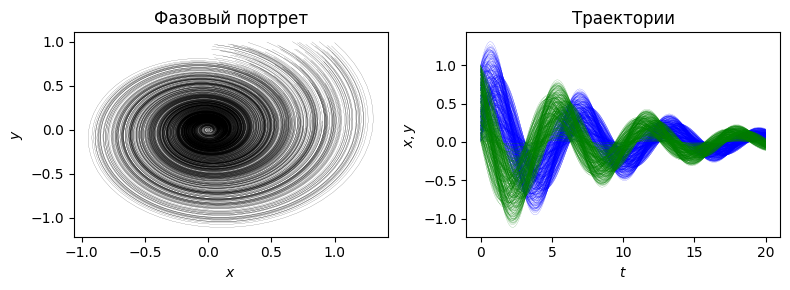

In [9]:
with torch.no_grad():
    y0 = torch.rand((300, 2)).to(device)
    t = torch.linspace(0., 20., 200).to(device)

    x, y = odeint(func, y0, t, method='rk4').transpose(0, -1).cpu()
    x, y = x.T, y.T

fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
ax[0].plot(x, y, c='k', linewidth=0.1)
ax[0].set_title('Фазовый портрет')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[1].plot(t.cpu(), x, c='b', linewidth=0.1)
ax[1].plot(t.cpu(), y, c='g', linewidth=0.1)
ax[1].set_title('Траектории')
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$x, y$')

plt.tight_layout()
plt.show()

<a name="sde"></a>
## Neural SDE

После выхода статьи NODEs в 2018 году ресерчеры осознали, что если моделировать сетями можно ОДУ, то значит можно и другие ДУ тоже моделировать через параметризацию нейронными сетями. Тогда в январе 2020 года [Scalable Gradients for Stochastic Differential Equations](https://arxiv.org/pdf/2001.01328.pdf) (AISTATS) вышла статья, которая рассматривает моделирование СДУ.

Рассмотрим задачу Коши уравнения
$$
\begin{cases}
dz(t) = \mu(z(t), t, \theta)dt + \sigma(z(t), t, \theta)dW(t), \\
z(t_0) = z_0
\end{cases}
$$
где $\mu$ — функция дрейфа, $\sigma$ — диффузии, $dW$ — многомерное Броуновское движение.

В данном случае в качестве Броуновского движения берется Винеровский процесс. Случайный процесс $W(t)$ называется Винеровским если
1. $W(0) = 0$ такое, что $P(W(0) = 0) = 1$
2. $W(t)$ такое, что $dW(t)$ — независимы
3. $W(t) - W(s)\sim\mathcal{N}(0, t-s),~\forall 0\leq s<t<\infty$

Для решения этого уранвения можно прибегнуть к "трюку"
$$
dz(t) = \mu(z(t), t, \theta)dt + \sigma(z(t), t, \theta)dW(t) \Rightarrow \dfrac{dz(t)}{dt} = \mu(z(t), t, \theta) + \sigma(z(t), t, \theta)\dfrac{dW(t)}{dt}
$$
что уже можно решать как задачу Коши ОДУ, например явным метолом Эйлера
$$
z_{i+1} = z_i + h\cdot\mu(z(t), t, \theta) + \sigma(z(t), t, \theta)\Delta{W_i}
$$

Но есть проблемы:
1. Как считать градиенты также эффективно как и для ОДУ?
2. Как хранить и скалировать $dW(t)$?

<a name="sde_adjoint"></a>
### Сопряженные состояния SDE и воспроизводимый шум

Для рассчета обратного распространения ошибки используется расширенное для СДУ сопряженное состояние. Для него добавляется сопряженное состояние для функции диффузии и рассчет воспроизводимого шума для броуновского движения.

<figure>
<img src="https://github.com/sswt/dive2gai/blob/main/.github/images/w12/adjoint.png?raw=true" alt="Scalable Gradients for Stochastic Differential Equations">
<figcaption align = "center">Source: Scalable Gradients for Stochastic Differential Equations</figcaption>
</figure>

<a name="bm"></a>
### Виртуальное броуновское дерево

Для обучения СДУ необходимо многократное численное решение уравнения. Для этого Броуновское движение должно быть
1. Воспроизводимым
2. Иметь возможность для получения промежуточных значений в случае методов высокого порядка

Таким образом нужно уметь эффективно хранить модель Броуновского движения и считать точки в любой момент $t$. Для этого авторы статьи предлагают алгоритм виртуального Броуновского дерева

<figure>
<img src="https://github.com/sswt/dive2gai/blob/main/.github/images/w12/brownian_tree.png?raw=true" alt="Scalable Gradients for Stochastic Differential Equations">
<figcaption align = "center">Source: Scalable Gradients for Stochastic Differential Equations</figcaption>
</figure>

Из описания алгоритма видно, что в нем используется алгоритм Броуновского моста, который позволяет получить произвольную точку внутри отрузка с фиксированными точками $w(t_s)$, $w(t_e)$ и вычисляется как
$$
w_m = dW(t_m)\sim\mathcal{N}\left(\dfrac{(t_e - t_m)w_s + (t_m - t_s)w_e}{t_e-t_s}, \dfrac{(t_e - t_m)(t_m - t_s)}{t_e-t_s}I_d\right)
$$
сам алгоритм представляет из себя метод бисекции, то есть итеративный поиск среднего значения для сокращения окна поиска вдвое до получения достаточно точного решения.

In [10]:
!pip install torchsde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.5 MB/s eta 0:00:00


In [11]:
from torchsde import BrownianInterval, sdeint

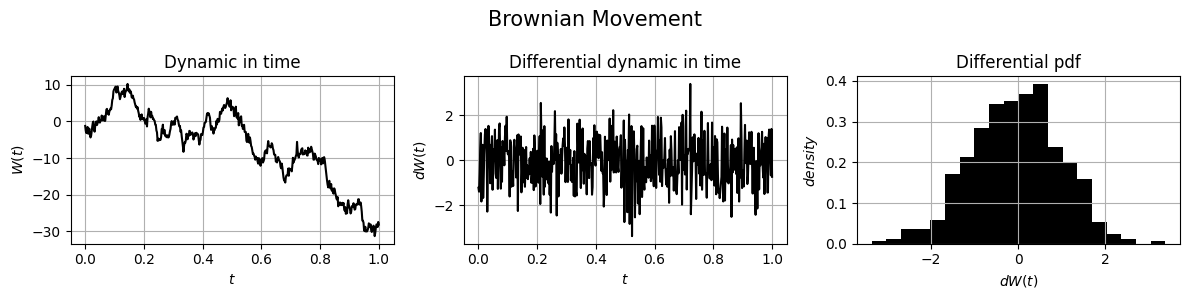

In [12]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

bm = BrownianInterval(t0=0.0, t1=1.0, size=(500, ))
t = torch.linspace(0., 1., 500)
dy = bm(0., 1.)
y = dy.cumsum(-1)

fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

plt.suptitle("Brownian Movement", size=15)

ax[0].plot(t, y, c='k')
ax[0].grid()
ax[0].set_title("Dynamic in time")
ax[0].set_xlabel("$t$")
ax[0].set_ylabel("$W(t)$")

ax[1].plot(t, dy, c='k')
ax[1].grid()
ax[1].set_title("Differential dynamic in time")
ax[1].set_xlabel("$t$")
ax[1].set_ylabel("$dW(t)$")

ax[2].hist(dy, density=True, color='k', bins='auto')
ax[2].grid()
ax[2].set_title("Differential pdf")
ax[2].set_xlabel("$dW(t)$")
ax[2].set_ylabel("$density$")

plt.tight_layout()
plt.show()

In [13]:
class SDE(nn.Module):

    def __init__(self):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    def f(self, t, y):
        """drift"""
        return torch.sin(t) + torch.tensor(0.1, device=y.device) * y

    def g(self, t, y):
        """diffusion"""
        return torch.tensor(0.3, device=y.device) * torch.sigmoid(torch.cos(t) * torch.exp(-y))

    def forward(self, t, y):
        """odeint"""
        return self.f(t, y) + self.g(t, y)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


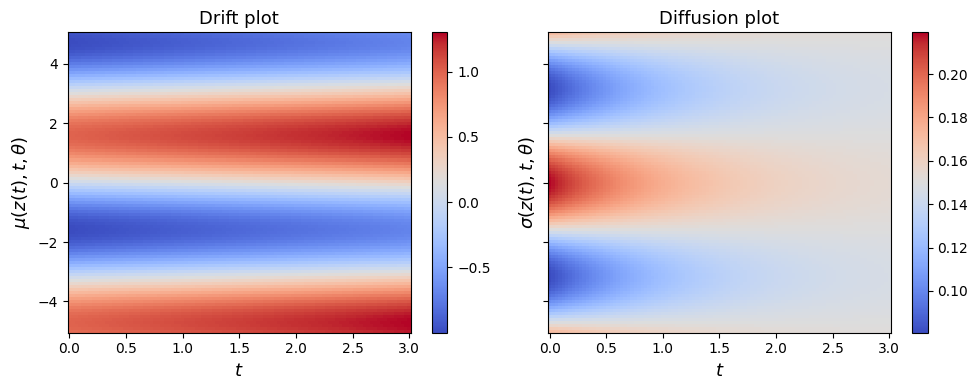

In [14]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

batch_size, state_size, t_size = 300, 1, 100
ts = torch.linspace(0, 3, t_size)
y0 = torch.linspace(-5, 5, t_size)
bm = BrownianInterval(t0=ts[0], t1=ts[-1], size=(batch_size, state_size))
sde = SDE()

T, Y = torch.meshgrid(ts, y0)

with torch.no_grad():
    F = sde.f(Y, T)
    G = sde.g(Y, T)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
im0 = ax[0].pcolormesh(T, Y, F, cmap='coolwarm')
ax[0].set_xlabel("$t$", size=13)
ax[0].set_ylabel("$\mu(z(t), t, \\theta)$", size=13)
ax[0].set_title("Drift plot", size=13)
im1 = ax[1].pcolormesh(T, Y, G, cmap='coolwarm')
ax[1].set_xlabel("$t$", size=13)
ax[1].set_ylabel("$\sigma(z(t), t, \\theta)$", size=13)
ax[1].set_title("Diffusion plot", size=13)
plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.tight_layout()
plt.show()

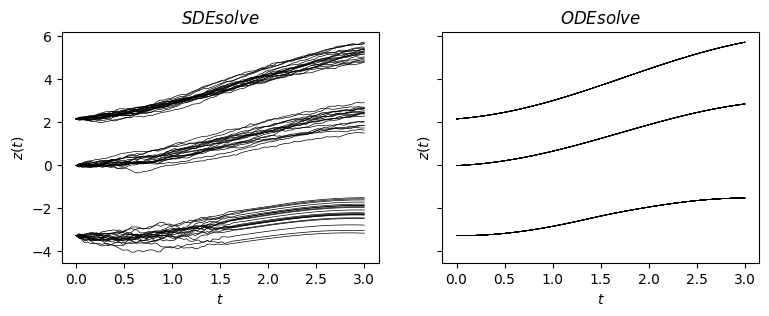

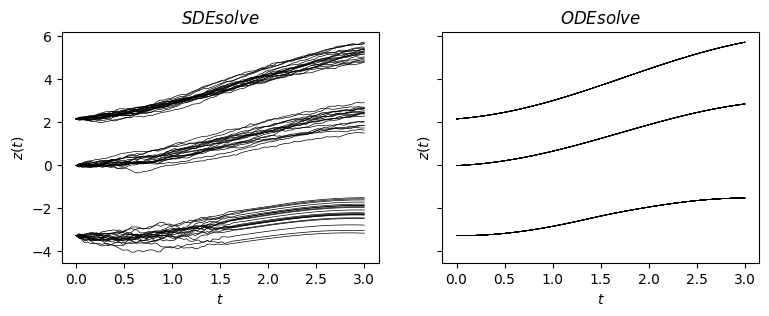

In [15]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

batch_size, state_size, t_size = 3, 20, 100
ts = torch.linspace(0, 3, t_size)
y0 = (8 * (torch.rand((batch_size, 1)) - 0.5))
y0 = torch.stack([y0 for i in range(state_size)], dim=1)[:, :, 0]
bm = BrownianInterval(t0=ts[0], t1=ts[-1], size=(batch_size, state_size))
sde = SDE()

for _ in range(2):

    with torch.no_grad():
        sde_ys = sdeint(sde, y0, ts, method="euler", bm=bm)
        ode_ys = odeint(sde, y0, ts, method="euler")

    fix, ax = plt.subplots(ncols=2, figsize=(9, 3), sharex=True, sharey=True)
    ax[0].plot(ts, sde_ys.flatten(1), c='k', linewidth=0.5)
    ax[0].set_xlabel('$t$')
    ax[0].set_ylabel('$z(t)$')
    ax[0].set_title('$SDE solve$')
    ax[1].plot(ts, ode_ys.flatten(1), c='k', linewidth=0.5)
    ax[1].set_xlabel('$t$')
    ax[1].set_ylabel('$z(t)$')
    ax[1].set_title('$ODE solve$')
    plt.show()

<a name="models"></a>
## Примеры использования

<a name="soilw"></a>
### Моделирование запасов продуктивной влаги в верхних слоях почвы методом нейронных дифференциальных уравнений

В 2022 году вышла статья в журнале росгидромета вышла статья [Моделирование запасов продуктивной влаги в верхних слоях почвы методом нейронных дифференциальных уравнений](https://method.meteorf.ru/publ/tr/tr385/07.pdf), где по некоторым гидродинамическим показателям (температура на поверхности, скорость ветра, влажность, количество осадков и т.д.), а также некоторые характеристики почвы. В качестве таргета берется ЗПВ на слоях 0-10мм и 10-20мм глубиной.

Так как прогноз выполняется с использованием непрогнозируемых параметров, в модель вводится дополнительный вектор $v(t)$.
$$
\begin{cases}
\dfrac{z(t)}{dt} = f(z(t), v(t), \theta) \\
z(t_0) = z_0
\end{cases}
$$
В качестве метрик используются, базирующаяся на MSE, которая считает отношение ошибки прогноза к ошибки, если бы прогноз брался за прошлый шаг (проверка на мартингал). То есть если метрика меньше 1, то модель делает "качественный прогноз", если больше 1, то модель бесполезна.
$$
RelMSE(\tilde{z}_1, z_1, z_0) = \dfrac{||z_1 - \tilde{z}_1||^2_2}{||z_1 - z_0||^2_2}
$$
Также вводится метрика CSI для оценки прогноза засухи. Для оценки засухи брались показатели ЗПВ меньше 5мм для слоя 0-10мм и меньше 10мм для слоя 10-20мм.
$$
CSI = \dfrac{TP}{TP+FN+FP}
$$

<figure>
<img src="https://github.com/sswt/dive2gai/blob/main/.github/images/w12/CSI_RelMSE.png?raw=true" alt="Метрики качества модели">
<figcaption align = "center">Метрики качества модели</figcaption>
</figure>

Ниже преведены примеры прогноза на месяц (720 часов). Видно что ЗПВ растет только при налии осадков.
<figure>
<img src="https://github.com/sswt/dive2gai/blob/main/.github/images/w12/27393_2016_19.png?raw=true" alt="Пример прогноза ЗПВ на месяц">
<img src="https://github.com/sswt/dive2gai/blob/main/.github/images/w12/34152_2016_14.png?raw=true" alt="Пример прогноза ЗПВ на месяц">
<figcaption align = "center">Пример прогноза ЗПВ на месяц</figcaption>
</figure>

<a name="climate"></a>
### Climate Modeling with Neural Diffusion Equations

В 2021 году вышла статья [Climate Modeling with Neural Diffusion Equations](https://arxiv.org/pdf/2111.06011.pdf) в которых нейронные ОДУ использовались для моделирования климатических характеристик. Эта модель интересна тем, что нейронные ОДУ тут использовались не для моделирования всего прогноза, а для аппроксимации ошибки физической модели. В качестве физической модели процесса использовалось дискретное представление уранение диффузии через оператор Лапласа (_The diffusion equation over a grid network uses the discrete Laplacian operator_)
$$
\dfrac{dh(t)}{dt} = -\Delta h(t) = -kLh(t) \Rightarrow h(t_1) = h(t_0) + \int\limits^{t_1}_{t_0}-kLh(t)dt
$$
где $k$ — коэффициент теплоемкости, $\Delta$ — дискретный оператор Лапласа, $L$ — матрица Киргофа (аналог оператора Лапласа для графов).

Полодим, что $\hat{h}(t_1)$ — истинное решение, тогда ошибку прогноза можно расписать как
$$
\varepsilon(t_1) = \hat{h}(t_1) - h(t_1) = \hat{h}(t_1) - h(t_0) - \int\limits^{t_1}_{t_0}-kLh(t)dt
$$
и эту ошибку можно аппроксимировать нейронной ОДУ
$$
\varepsilon(t_1) \approx \int\limits_{t_0}^{t_1} f(h(t), t, \theta)dt
$$
Тогда конечная модель имеет вид
$$
\hat{h}(t_1) \approx h(t_0) + \int\limits^{t_1}_{t_0}-kLh(t)dt + \int\limits_{t_0}^{t_1} f(h(t), t, \theta)dt = h(t_0) + \int\limits^{t_1}_{t_0}\left[-kLh(t) + f(h(t), t, \theta)\right]dt
$$
ниже приведена иллюстрация модели из статьи
<figure>
<img src="https://github.com/sswt/dive2gai/blob/main/.github/images/w12/nde-scheme.png?raw=true" alt="Climate Modeling with Neural Diffusion Equations">
<figcaption align = "center">Модель прогноза климата</figcaption>
</figure>
Метрики качества приведены в таблице
<figure>
<img src="https://github.com/sswt/dive2gai/blob/main/.github/images/w12/nde-table.png?raw=true" alt="Climate Modeling with Neural Diffusion Equations">
<figcaption align = "center">Метрики качества на одном из экспериментов</figcaption>
</figure>
видно, что модель без нейронной ОДУ или только лишь с ней работают хуже.